# Subsampling window log exploration

Load all window logs from the subsampling results and plot cumulative flux time series per site.
Legends include kept fractions and relative bias computed from the plotted cumsums (avoids CSV NaN/inf issues).

In [67]:
import pathlib as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import blended_transform_factory

sns.set_context("talk")
%matplotlib inline

ROOT = pl.Path(r"C:\\Users\\geryatejina\\dev\\minspecs_eddy\\subsampling_results")
AGG_PATH = ROOT / "subsampling_5sites_full_period.csv"

In [68]:
def load_window_log(path: pl.Path) -> pd.DataFrame:
    """Load a wide window-level log CSV."""
    return pd.read_csv(path)


def get_labels(df: pd.DataFrame, flux: str = "CO2") -> list:
    prefix = f"F_{flux}_"
    ref_col = f"F_{flux}_ref"
    return [c[len(prefix):] for c in df.columns if c.startswith(prefix) and c != ref_col]


def log_summary(df: pd.DataFrame):
    """Quick overview of the log."""
    print(f"rows: {len(df):,}")
    if "window_start" in df:
        print("time span:", df["window_start"].min(), "→", df["window_start"].max())
    print("numeric columns:", len(df.select_dtypes(include="number").columns))
    for flux in ["CO2", "LE", "H"]:
        labels = get_labels(df, flux=flux)
        print(f"labels for {flux}: {labels}")


def parse_site_key(path: pl.Path) -> str:
    parts = path.stem.split("_")
    if len(parts) >= 3:
        eco = parts[1] if parts[0].lower() == "igbp" else parts[0]
        site = parts[2]
        return f"{eco}_{site}"
    return path.stem


def load_all_logs(root: pl.Path = ROOT, pattern: str = "*_windows_*.csv") -> dict:
    """Glob root for window logs and return a dict keyed by ecosystem_site."""
    logs = {}
    for p in sorted(root.glob(pattern)):
        try:
            logs[parse_site_key(p)] = load_window_log(p)
        except Exception as exc:
            print(f"Skipping {p.name}: {exc}")
    return logs


def load_kept_fraction_map(path: pl.Path = AGG_PATH) -> dict:
    """Return mapping {(eco_site): {label: kept_fraction_mean}} from aggregated results."""
    if not path.exists():
        return {}
    df = pd.read_csv(path)
    df["key"] = df["ecosystem"].apply(lambda x: x.split("_")[-1] if isinstance(x, str) else x) + "_" + df["site"]
    kept = {}
    for (key, label), grp in df.groupby(["key", "subsample_label"]):
        kept.setdefault(key, {})[label] = grp["kept_fraction_mean"].mean()
    return kept


def cumsum_flux_subplots(
    logs: dict,
    flux: str = "CO2",
    label_filter: list | None = None,
    include_raw: bool = False,
    figsize: tuple | None = None,
    cmap: str = "Dark2",
    legend_ncol: int = 1,
    y_limits: tuple | None = None,
    quantile_clip: tuple | None = None,
    kept_lookup: dict | None = None,
):
    """
    Plot cumulative flux for each site in stacked subplots (one column), harmonizing y-limits.
    - kept_lookup: optional {site: {label: kept_fraction_mean}}
    Rel bias is computed from the plotted cumulative series: (cum_deg[-1]-cum_ref[-1]) / |cum_ref[-1]|.
    """
    if not logs:
        print("No logs provided.")
        return
    n = len(logs)
    if figsize is None:
        figsize = (12, 3 * n)

    y_min, y_max = (y_limits if y_limits is not None else (np.inf, -np.inf))
    all_series = {}
    site_max_bias = {}

    for key, df_site in logs.items():
        ref_col = f"F_{flux}_ref"
        if ref_col not in df_site.columns:
            continue
        labels = get_labels(df_site, flux=flux)
        if label_filter:
            labels = [lbl for lbl in labels if lbl in label_filter]
        if not labels:
            continue

        working = df_site.copy()
        if quantile_clip:
            ref_vals = working[ref_col].dropna()
            if not ref_vals.empty:
                lo = ref_vals.quantile(quantile_clip[0])
                hi = ref_vals.quantile(quantile_clip[1])
                working = working[(working[ref_col] >= lo) & (working[ref_col] <= hi)]

        cols_needed = [ref_col] + [f"F_{flux}_{lbl}" for lbl in labels]
        if include_raw:
            raw_col = f"F_{flux}_raw"
            if raw_col in working.columns:
                cols_needed.append(raw_col)
        mask = working[cols_needed].notna().all(axis=1)
        aligned = working.loc[mask].copy()
        aligned["window_start"] = pd.to_datetime(aligned["window_start"])
        aligned.sort_values("window_start", inplace=True)
        if aligned.empty:
            continue

        series = []
        ref_df = aligned.drop_duplicates(subset=["window_start"])
        ref_df["cum_ref"] = ref_df[ref_col].cumsum() - ref_df[ref_col].iloc[0]
        series.append(("ref", ref_df["window_start"], ref_df["cum_ref"], "black", None))
        if y_limits is None:
            y_min = min(y_min, np.nanmin(ref_df["cum_ref"]))
            y_max = max(y_max, np.nanmax(ref_df["cum_ref"]))

        palette = sns.color_palette(cmap, len(labels))
        max_bias_val = None
        cum_ref_end = ref_df["cum_ref"].iloc[-1]
        for lbl, color in zip(labels, palette):
            col = f"F_{flux}_{lbl}"
            g = aligned[["window_start", col]].copy()
            g["cum_deg"] = g[col].cumsum() - g[col].iloc[0]
            bias_val = None
            if np.isfinite(cum_ref_end) and abs(cum_ref_end) > 0:
                cum_deg_end = g["cum_deg"].iloc[-1]
                bias_val = (cum_deg_end - cum_ref_end) / abs(cum_ref_end) * 100.0
            series.append((lbl, g["window_start"], g["cum_deg"], color, bias_val))
            if y_limits is None:
                y_min = min(y_min, np.nanmin(g["cum_deg"]))
                y_max = max(y_max, np.nanmax(g["cum_deg"]))
            if bias_val is not None and np.isfinite(bias_val):
                max_bias_val = bias_val if max_bias_val is None else max(max_bias_val, bias_val)

        if max_bias_val is not None:
            site_max_bias[key] = max_bias_val
        all_series[key] = series

    if not all_series:
        print("No usable series to plot.")
        return

    fig, axes = plt.subplots(len(all_series), 1, figsize=figsize, sharex=False)
    if len(all_series) == 1:
        axes = [axes]

    for ax, (key, series) in zip(axes, all_series.items()):
        for lbl, xvals, yvals, color, bias_val in series:
            style = "--" if lbl == "ref" else "-"
            lw = 1.5 if lbl == "ref" else 1.2
            legend_label = lbl
            if kept_lookup and key in kept_lookup and lbl in kept_lookup[key] and lbl != "ref":
                frac = kept_lookup[key][lbl]
                if pd.notna(frac):
                    legend_label = f"{legend_label} ({frac*100:.0f}%)"
            if bias_val is not None and np.isfinite(bias_val) and lbl != "ref":
                legend_label = f"{legend_label} ({bias_val:+.1f}%)"
            ax.plot(xvals, yvals, label=legend_label, linestyle=style, linewidth=lw, color=color)
        ax.set_title(key, fontsize=10)
        ax.set_ylabel(f"cumsum F_{flux}", fontsize=9)
        ax.tick_params(axis="both", labelsize=8)
        ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, ncol=legend_ncol)
        ax.set_ylim(y_min, y_max)

        if key in site_max_bias and np.isfinite(site_max_bias[key]):
            txt = f"max rel bias: {site_max_bias[key]:+.1f}%"
            trans = blended_transform_factory(ax.transData, ax.transAxes)
            xmax = max(series[0][1]) if series and series[0][1].size else 0
            ax.text(xmax, 0.98, txt, transform=trans, ha="right", va="top", fontsize=9)

    axes[-1].set_xlabel("window_start", fontsize=9)
    fig.tight_layout()
    plt.show()

rows: 11,288
time span: 2023-01-02T00:30:00 → 2023-09-02T00:00:00
numeric columns: 31
labels for CO2: ['decimate_2', 'decimate_5', 'decimate_10', 'ogive_stop_loose', 'burst_5_25', 'burst_10_50', 'burst_10_110', 'diurnal_burst_day_high_night_low', 'diurnal_decimate_day_high_night_low']
labels for LE: ['decimate_2', 'decimate_5', 'decimate_10', 'ogive_stop_loose', 'burst_5_25', 'burst_10_50', 'burst_10_110', 'diurnal_burst_day_high_night_low', 'diurnal_decimate_day_high_night_low']
labels for H: ['decimate_2', 'decimate_5', 'decimate_10', 'ogive_stop_loose', 'burst_5_25', 'burst_10_50', 'burst_10_110', 'diurnal_burst_day_high_night_low', 'diurnal_decimate_day_high_night_low']


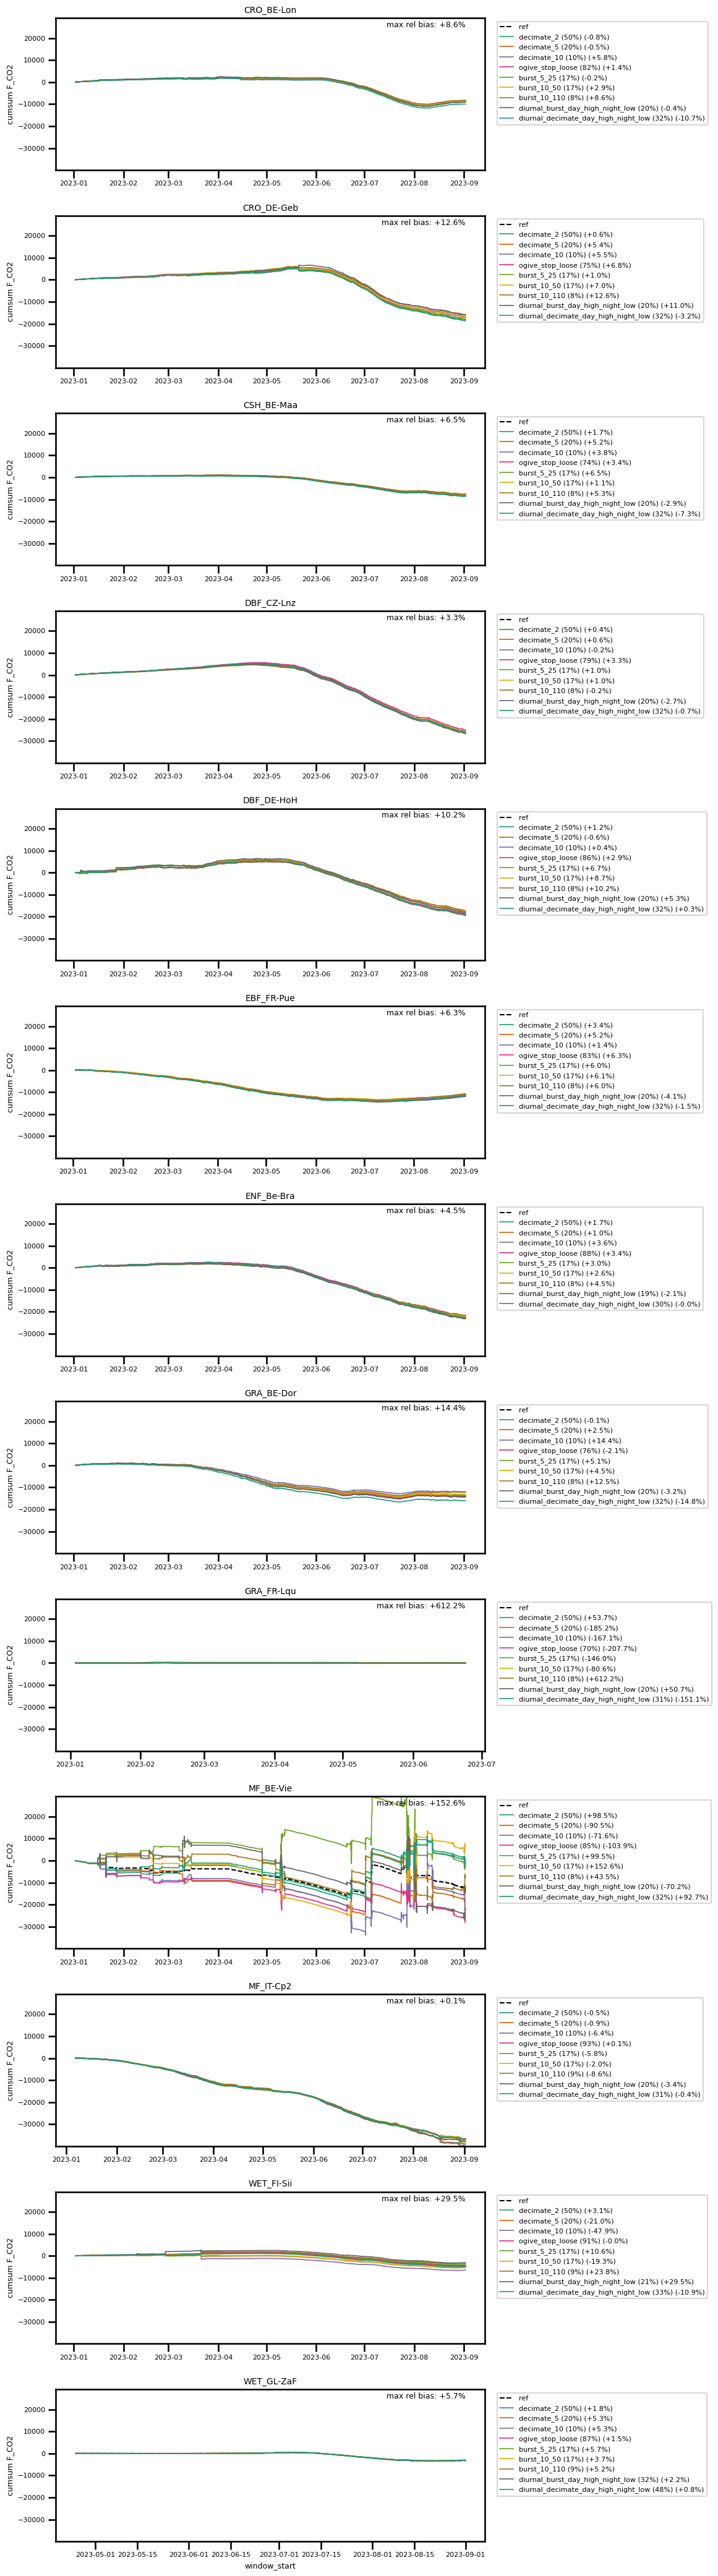

In [69]:
# Example: load all logs and plot cumulative CO2 cumsums in stacked subplots, with kept fractions and rel bias in legend
all_logs = load_all_logs()
kept_map = load_kept_fraction_map()
if all_logs:
    log_summary(next(iter(all_logs.values())))
    cumsum_flux_subplots(
        all_logs,
        flux="CO2",
        cmap="Dark2",
        quantile_clip=None,  # e.g., (0.03, 0.97) to drop extremes
        kept_lookup=kept_map,
    )
else:
    print("No logs found in ROOT.")